In [228]:
import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string


In [229]:
#getting the data
df = pd.read_csv('data/songdata.csv')
df = df.iloc[:200,:]

In [230]:
list(df)

['artist', 'song', 'link', 'text']

In [231]:
song_lyrics = list(df['text'])

## Exploratory Analysis
We look at basic statistics like dataset size, average number of words in titles and lyrics, distribution of unique word counts

In [232]:
print("Dataset size:", df.shape[0])

Dataset size: 200


In [233]:
print("\nExample song lyrics:\n", song_lyrics[2])


Example song lyrics:
 I'll never know why I had to go  
Why I had to put up such a lousy rotten show  
Boy, I was tough, packing all my stuff  
Saying I don't need you anymore, I've had enough  
And now, look at me standing here again 'cause I found out that  
Ma ma ma ma ma ma ma ma ma ma ma ma ma ma ma ma my life is here  
Gotta have you near  
  
As good as new, my love for you  
And keeping it that way is my intention  
As good as new and growing too  
Yes, I think it's taking on a new dimension  
It's as good as new, my love for you  
Just like it used to be and even better  
As good as new, thank God it's true  
Darling, we were always meant to stay together  
  
Feel like a creep, never felt so cheap  
Never had a notion that my love could be so deep  
How could I make such a dumb mistake  
Now I know I'm not entitled to another break  
But please, baby, I beg you to forgive 'cause I found out that  
Ma ma ma ma ma ma ma ma ma ma ma ma ma ma ma ma my life is here  
Gotta get yo

In [234]:
del df

In [235]:
def mean_words(text_list):
    tokens = list(map(lambda x: len(x.split()), text_list))
    return np.mean(tokens)

print("\nMean number of words in song lyrics:", mean_words(song_lyrics))


Mean number of words in song lyrics: 241.94


In [236]:
from collections import Counter

def most_fequent(text_list,start,stop):
    '''
    Get most frequent words and their counts
    Input:
        -text_list: List of strings
        -start, stop: int, int. They represent the range of the most frequent word
    Output:
        -List of tuples
    '''
    vocab = []
    for text in text_list:
        vocab.extend(text.split())
        
    word_count = dict(Counter(vocab))
    word_count = sorted(word_count.items(), key  = lambda x: x[1], reverse = True)
    
    print("Most frequent n words",word_count[start:stop])
    print("Total number of words", len(vocab))
    print("Total number of unique words", len(set(vocab)))
            


In [237]:
print("For lyrics:\n")
most_fequent(song_lyrics, 0, 5)

For lyrics:

Most frequent n words [('the', 1764), ('I', 1734), ('you', 1189), ('a', 1177), ('to', 880)]
Total number of words 48388
Total number of unique words 5238


In [238]:
def groupby_counts(text_list, count):
    '''
    Computes fraction of unique words by their counts in the dataset
    Input:
        -text_list: List of strings
        -count: int. Count for which fraction of unique tokens should be obtained
    Output:
        -fraction: float <1, >0
    '''
    vocab = []
    for text in text_list:
        vocab.extend(text.split())
        
    word_count = dict(Counter(vocab))
    count_n_words = [key for key,value in word_count.items() if value == count]
    
    return len(count_n_words)/len(word_count)

Text(0.5, 1.0, 'Fraction of unique words vs Counts (lyrics)')

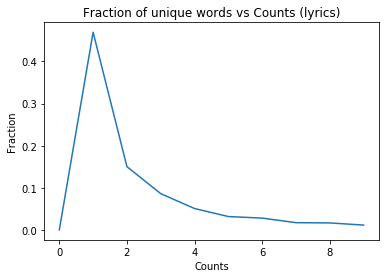

In [239]:
counts = list(range(10))
fraction = [groupby_counts(song_lyrics, count) for count in counts]
plt.plot(counts, fraction)
plt.xlabel('Counts')
plt.ylabel('Fraction')
plt.title("Fraction of unique words vs Counts (lyrics)")

## Conclusion
Since more than 60% of words in the song lyrics occur less than or equal to 2 times, replacing them with <UNK> token would eliminate most of our vocabulary. Hence we decide to use subword models like character level LSTM

## Data Cleaning
We perform text normalization like removal of punctuation, lowercasing, etc. We also add tags like <NEW> - new line, <START> - start of a song, <END> - end of a song

In [240]:
punctuation = string.punctuation

def normalize(string, punctuation = punctuation):
    '''
    Perform normalizing operations like lowercasing, removing
    punctuation
    
    -Input: 
        string: string to be normalized
        punctuation: string of uniuqe punctuation characters
        
    -Output:
        a normalized string
    '''
    string = string.lower()
    transtable = str.maketrans('', '', punctuation)
    string = string.translate(transtable)
    return string

In [241]:
print("Example of normalized lyrics: \n")
print(normalize(song_lyrics[0]))

Example of normalized lyrics: 

look at her face its a wonderful face  
and it means something special to me  
look at the way that she smiles when she sees me  
how lucky can one fellow be  
  
shes just my kind of girl she makes me feel fine  
who could ever believe that she could be mine  
shes just my kind of girl without her im blue  
and if she ever leaves me what could i do what could i do  
  
and when we go for a walk in the park  
and she holds me and squeezes my hand  
well go on walking for hours and talking  
about all the things that we plan  
  
shes just my kind of girl she makes me feel fine  
who could ever believe that she could be mine  
shes just my kind of girl without her im blue  
and if she ever leaves me what could i do what could i do




In [242]:
#normalizing lyrics
song_lyrics = list(map(normalize, song_lyrics))


In [243]:
#defining tags for constructing char to index dictionary
NEW_LINE = '!'
SPACE = ' '
additional_chars = NEW_LINE + SPACE 


def char_dict(additional_chars):
    '''
    Build character to unique index mapping and vice versa
    -Input: additional non numeric non alphabetical characters
            for example - '? !' has three such characters
            
    -Output: 2 dictionaries. char2index (character to index mapping)
             and index2char (reverse mapping of char2index)
    '''
    char_set = list(string.ascii_lowercase + string.digits + additional_chars)
    index2char = dict(enumerate(char_set))
    char2index = {value:key for key,value in index2char.items()}
    
    return char2index, index2char

In [244]:
char2index, index2char = char_dict(additional_chars)

In [245]:
print(char2index)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '0': 26, '1': 27, '2': 28, '3': 29, '4': 30, '5': 31, '6': 32, '7': 33, '8': 34, '9': 35, '!': 36, ' ': 37}


In [246]:
print(index2char)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 9: 'j', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y', 25: 'z', 26: '0', 27: '1', 28: '2', 29: '3', 30: '4', 31: '5', 32: '6', 33: '7', 34: '8', 35: '9', 36: '!', 37: ' '}


In [247]:
NEW_LINE = '!'
def add_tags(string, new_line):
    string = re.subn(r'\n',new_line + ' ', string)[0]
    
    return string

In [248]:
song_lyrics = list(map(lambda x: add_tags(x, new_line = NEW_LINE), song_lyrics))


In [249]:
print("Transformed song lyrics:\n {} \n".format(song_lyrics[0]))

Transformed song lyrics:
 look at her face its a wonderful face  ! and it means something special to me  ! look at the way that she smiles when she sees me  ! how lucky can one fellow be  !   ! shes just my kind of girl she makes me feel fine  ! who could ever believe that she could be mine  ! shes just my kind of girl without her im blue  ! and if she ever leaves me what could i do what could i do  !   ! and when we go for a walk in the park  ! and she holds me and squeezes my hand  ! well go on walking for hours and talking  ! about all the things that we plan  !   ! shes just my kind of girl she makes me feel fine  ! who could ever believe that she could be mine  ! shes just my kind of girl without her im blue  ! and if she ever leaves me what could i do what could i do! !  



In [250]:
def index_string(string, char2index):
    sequence = [char2index[str(char)] for char in string]
    return sequence

In [251]:
print(index_string(song_lyrics[0], char2index))

[11, 14, 14, 10, 37, 0, 19, 37, 7, 4, 17, 37, 5, 0, 2, 4, 37, 8, 19, 18, 37, 0, 37, 22, 14, 13, 3, 4, 17, 5, 20, 11, 37, 5, 0, 2, 4, 37, 37, 36, 37, 0, 13, 3, 37, 8, 19, 37, 12, 4, 0, 13, 18, 37, 18, 14, 12, 4, 19, 7, 8, 13, 6, 37, 18, 15, 4, 2, 8, 0, 11, 37, 19, 14, 37, 12, 4, 37, 37, 36, 37, 11, 14, 14, 10, 37, 0, 19, 37, 19, 7, 4, 37, 22, 0, 24, 37, 19, 7, 0, 19, 37, 18, 7, 4, 37, 18, 12, 8, 11, 4, 18, 37, 22, 7, 4, 13, 37, 18, 7, 4, 37, 18, 4, 4, 18, 37, 12, 4, 37, 37, 36, 37, 7, 14, 22, 37, 11, 20, 2, 10, 24, 37, 2, 0, 13, 37, 14, 13, 4, 37, 5, 4, 11, 11, 14, 22, 37, 1, 4, 37, 37, 36, 37, 37, 37, 36, 37, 18, 7, 4, 18, 37, 9, 20, 18, 19, 37, 12, 24, 37, 10, 8, 13, 3, 37, 14, 5, 37, 6, 8, 17, 11, 37, 18, 7, 4, 37, 12, 0, 10, 4, 18, 37, 12, 4, 37, 5, 4, 4, 11, 37, 5, 8, 13, 4, 37, 37, 36, 37, 22, 7, 14, 37, 2, 14, 20, 11, 3, 37, 4, 21, 4, 17, 37, 1, 4, 11, 8, 4, 21, 4, 37, 19, 7, 0, 19, 37, 18, 7, 4, 37, 2, 14, 20, 11, 3, 37, 1, 4, 37, 12, 8, 13, 4, 37, 37, 36, 37, 18, 7, 4, 18, 37, 

In [252]:
song_lyrics_indexed = list(map(lambda x: index_string(x, char2index), song_lyrics))


In [253]:
def length_distribution(seq_list):
    '''
    Prints median, value at 90th percentile and plts a density plt
    Input:
        -list of numbers
    '''
    lengths = [len(seq) for seq in seq_list]
    print("median:",np.median(lengths))
    print("90th percentile", np.quantile(lengths,0.9))
    sns.kdeplot(lengths)

Plot for distribution of number of characters in a song lyrics

median: 1222.0
90th percentile 1891.0999999999997


/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


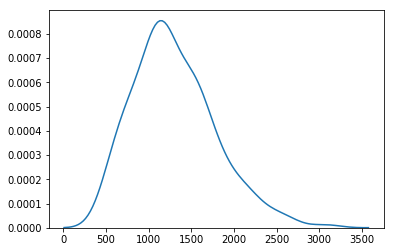

In [254]:
print("Plot for distribution of number of characters in a song lyrics\n")
length_distribution(song_lyrics)

In [255]:
#to save memory
del song_lyrics

In [256]:
from itertools import chain
song_lyrics_indexed = list(chain.from_iterable(song_lyrics_indexed))

In [257]:
MAXLEN_LYRICS = 51
def chunk(indexed_list, max_len):
    '''
    Returns a list of list (length = max_len) from a list of integers
    Input:
        indexed_list: List of integers
        max_len: length of chunks
    Output:
        list of list (of length = max_len)
    '''
    lyrics = []
    for i in range(0,len(indexed_list)-max_len):
        lyrics.append(indexed_list[i:i+max_len])
    return lyrics

song_lyrics_indexed = chunk(song_lyrics_indexed, MAXLEN_LYRICS)

In [258]:
len(song_lyrics_indexed)

260279

## Make Input and Target Sequence

In [259]:
song_lyrics_input = [lyrics[:-1] for lyrics in song_lyrics_indexed]
song_lyrics_target = [lyrics[-1:] for lyrics in song_lyrics_indexed]

In [260]:
print("Example input and target sequence")
print(song_lyrics_input[1])
print(song_lyrics_target[1])

Example input and target sequence
[14, 14, 10, 37, 0, 19, 37, 7, 4, 17, 37, 5, 0, 2, 4, 37, 8, 19, 18, 37, 0, 37, 22, 14, 13, 3, 4, 17, 5, 20, 11, 37, 5, 0, 2, 4, 37, 37, 36, 37, 0, 13, 3, 37, 8, 19, 37, 12, 4, 0]
[13]


In [261]:
if torch.cuda.is_available():
    device = 'cuda'
    
else:
    device = 'cpu'

In [262]:
song_lyrics_input = torch.LongTensor(np.array(song_lyrics_input)).to(device)

song_lyrics_target = torch.LongTensor(np.array(song_lyrics_target)).to(device)

In [263]:
song_lyrics_input.shape[0]

260279

In [264]:
TRAIN_SIZE = int(0.9*song_lyrics_input.shape[0])
train_X = song_lyrics_input[:TRAIN_SIZE]
train_y = song_lyrics_target[:TRAIN_SIZE]

test_X = song_lyrics_input[TRAIN_SIZE:]
test_y = song_lyrics_target[TRAIN_SIZE:]

In [265]:
del song_lyrics_input, song_lyrics_target

In [266]:
import boto3
import sagemaker
from sagemaker import get_execution_role

In [267]:
# SageMaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# default S3 bucket
bucket = sagemaker_session.default_bucket()

In [268]:
import pickle
import os
def save_sequence(sequence, filename, PATH):
    '''
    saves sequence to specified directory
    '''
    if not os.path.exists(PATH):
        os.makedirs(PATH)
        
    data_dir = os.path.join(PATH, filename)
    with open(data_dir,'wb') as file:
        pickle.dump(sequence,file)


In [269]:
save_sequence(train_X,'input.pkl','data/')
save_sequence(train_y,'target.pkl','data/')

In [270]:
def load_sequence(filename, PATH):
    '''
    loads sequence data from the specified directory
    '''
    data_dir = os.path.join(PATH, filename)
    with open(data_dir,'rb') as file:
        data = pickle.load(file)
    
    return data

In [271]:
# specify where to upload in S3
prefix = 'lyrics-data'
data_dir = 'data'

# upload to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

s3://sagemaker-ap-south-1-806732165461/lyrics-data


In [272]:
# iterate through S3 objects and print contents
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
     print(obj.key)

lyrics-data/input.pkl
lyrics-data/sagemaker-pytorch-2019-08-30-07-50-42-869/output/model.tar.gz
lyrics-data/sagemaker-pytorch-2019-08-30-11-24-45-374/output/model.tar.gz
lyrics-data/sagemaker-pytorch-2019-08-30-12-59-29-282/output/model.tar.gz
lyrics-data/songdata.csv
lyrics-data/target.pkl
sagemaker-pytorch-2019-08-30-07-50-42-869/source/sourcedir.tar.gz
sagemaker-pytorch-2019-08-30-10-27-19-780/source/sourcedir.tar.gz
sagemaker-pytorch-2019-08-30-10-30-51-510/source/sourcedir.tar.gz
sagemaker-pytorch-2019-08-30-10-49-40-107/sourcedir.tar.gz
sagemaker-pytorch-2019-08-30-10-49-41-475/sourcedir.tar.gz
sagemaker-pytorch-2019-08-30-11-08-08-876/sourcedir.tar.gz
sagemaker-pytorch-2019-08-30-11-24-45-374/source/sourcedir.tar.gz
sagemaker-pytorch-2019-08-30-11-40-03-817/sourcedir.tar.gz
sagemaker-pytorch-2019-08-30-12-06-56-258/sourcedir.tar.gz
sagemaker-pytorch-2019-08-30-12-24-29-392/sourcedir.tar.gz
sagemaker-pytorch-2019-08-30-12-40-00-722/sourcedir.tar.gz
sagemaker-pytorch-2019-08-30-12

## Model Building
We now move on to building our model. First we focus on building a CNN encoder, then a decoder

### LSTM Model Script

In [273]:
!pygmentize source/model.py

import pandas as pd
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import re
import string



class DecoderLSTM(nn.Module):
    def __init__(self, embedding_dim, vocab_size, hidden_size, num_layers, dropout = 0.5):
        super(DecoderLSTM, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = dropout
        
        self.lstm = nn.LSTM(self.embedding_dim, self.hidden_size, self.num_layers, 
                            dropout = dropout, batch_first = True)
        self.linear = nn.Linear(hidden_size, self.vocab_size)
        
    def forward(self, x): 
        output = self.embedding(x)
        output,_ = self.lstm(output)
    

In [274]:
HIDDEN_DIM = 512
NUM_LAYERS = 2
INPUT_LEN = MAXLEN_LYRICS-1
EMBEDDING_DIM = 256

In [275]:
# import a PyTorch wrapper
from sagemaker.pytorch import PyTorch

# specify an output path
# prefix is specified above
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate a pytorch estimator
estimator = PyTorch(entry_point='train.py',
                    source_dir='source', # this should be just "source" for your code
                    role=role,
                    framework_version='1.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'embedding_dim':256,  # num of features
                        'hidden_dim': 512,
                        'vocab_size': len(char2index),
                        'epochs': 10 
                    })

In [276]:
%%time 
# train the estimator on S3 training data
estimator.fit({'train': input_data})

2019-08-31 11:53:26 Starting - Starting the training job...
2019-08-31 11:53:31 Starting - Launching requested ML instances......
2019-08-31 11:54:28 Starting - Preparing the instances for training......
2019-08-31 11:55:49 Downloading - Downloading input data
2019-08-31 11:55:49 Training - Downloading the training image......
2019-08-31 11:56:52 Training - Training image download completed. Training in progress..
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2019-08-31 11:56:52,996 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2019-08-31 11:56:53,021 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2019-08-31 11:56:54,438 sagemaker_pytorch_container.training INFO     Invoking user training script.
2019-08-31 11:56:54,681 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2019-08-31 11:56:54,682 sagema

In [297]:
# importing PyTorchModel
from sagemaker.pytorch import PyTorchModel

# Create a model from the trained estimator data
# And point to the prediction script
model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='1.0',
                     entry_point='predict.py',
                     source_dir='source')

In [ ]:
%%time
# deploy and create a predictor
predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-------------------------------------------------------------------------------------------------------------!CPU times: user 637 ms, sys: 37.4 ms, total: 674 ms
Wall time: 9min 16s


### Measure Accuracy


In [303]:
# train = torch.utils.data.TensorDataset(song_lyrics_input,song_lyrics_target)
# train_loader = torch.utils.data.DataLoader(train, batch_size = 128, shuffle=True)
def compute_accuracy(model, test_X, test_y):
    '''
    Computes test accuracy from a model
    -Input:
        model: PyTorch model endpoint
        test_X: test input of shape (number of datapoints, INPUT_LEN (=50))
        test_y: test input of shape (number of datapoints, -1)
    -Output:
        accuracy: float
    '''
    output = model.predict(Variable(torch.LongTensor(test_X).to('cpu').view(-1, INPUT_LEN)))
    output = torch.argmax(torch.from_numpy(output), dim=1 )
    output = output.view(-1)
    test_y = test_y.view(-1)
    accuracy = float(torch.sum(output == test_y))/float(output.size(-1))
    return accuracy

score = []
for i in range(test_X.shape[0]-1):
    score.append(compute_accuracy(predictor, test_X[i:i+1], test_y[i:i+1]))
#connection failed error for larger sizes of test set
sum(score)/len(score)

0.5883537813587255

## Generate Predictions

In [225]:
def sample(preds, temperature=1.0):
    '''
    Randomly samples character based on output probabilities
    Input:
        -preds: model prediction (of the size = vocab_size)
    '''
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [315]:
# Define the start sentence
sentence = 'it was summer ! i was having the best time of my life'

variance = 0.4
generated = ''
original = sentence
window = sentence

for i in range(400):
    generate = index_string(sentence, char2index)[-INPUT_LEN:]
#     print(generate)
    # Change the sentence to index vector shape (1,50)
        
    x_in = Variable(torch.LongTensor(generate).to('cpu')).view(-1,INPUT_LEN)
    pred = predictor.predict(x_in)
    pred = torch.from_numpy(pred)
    pred = np.array(F.softmax(pred, dim=1).data[0].cpu())
    pred = torch.from_numpy(pred)
    next_index = sample(pred, variance)
    next_char = index2char[next_index] # index to char

    generated += next_char
    sentence += next_char # Update Window for next char predict
    
print(sentence.replace('!','\n'))

it was summer 
 i was having the best time of my life  
 when you can hear them will didnt he  
 you can do magic  
 i wont let you go  
 what is right for me  
 what about livingstone  
   
 we wish i would lose her  
 were gonna live a little love affairs  
   
 nina pretty ballerina now thats all the fun  
 suppper trooppper  
 smiling having for these visitors  
 my friends do  
   
 im a bird dog  
 they drum the way that you try and the lights


In [316]:
predictor.delete_endpoint()